# Introduction to NEXRAD Radar Files
This notebook is meant to be added to, modified, etc. by both of us so feel free to make changes! Remember, as long as you commit, gitlab keeps old versions!

This notebook has two main goals:

1. Learn how to work with and interpret radar files using py-ART and a few other common Python packages (mainly numpy)
2. Learn how to collaborate on a file in git


* Instructions:
  - Create a Python environment using [this guide from py-ART](https://arm-doe.github.io/pyart/#install). Make sure you also include jupyter so you can load the notebook! I recommend using conda for this, as the installation guide suggests. If you already have an environment containing all these packages, you can use that instead.
  
  - Download NEXRAD level-2\* file from NOAA Big Data Program: https://s3.amazonaws.com/noaa-nexrad-level2/index.html. Try to think of a time when it rained, and pull the files from that time. The archive here goes back several years, so the files will be there. You'll use the KCXX radar in Burlington, VT, as Montreal is in range of this radar. Note that all times are in UTC in this archive.
  
  - Have fun! I've included some exercises in here along with the examples shown, to give you some experience doing this for yourself. Feel free to look around the internet and see what cool things people have done with it. They also provide a [notebook gallery](https://arm-doe.github.io/pyart/notebook-gallery.html) which shows some examples of how to work with the py-ART radar object, manipulating the radar object fields, etc. 
  
\* Note: "level" here refers to amount of processing done on the data. Level-1 is raw radar data, no one uses this. Level 2 is the processed radar data that includes things like reflectivity, Doppler velocity, polarimetric variables. Level-3 files are even more processed and include things like storm-relative velocity, vertically integrated liquid (VIL), basically additional products that can be computed from the base level 2 data. I chose level-2 data for these introductory things because there's a somewhat limited amount of variables to look at, so it's a bit less overwhelming. :)

Let me know if anything doesn't work or you find bugs. This is for your education, I don't want my subpar coding skills to get in the way!

In [1]:
from math import radians, sin, cos, asin, sqrt
import numpy as np
import pyart
from scipy.spatial import KDTree


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


In [2]:
import cartopy.crs as ccrs

## Helper Functions

In [3]:
def haversine(lon1, lat1, lon2, lat2):
    '''
    Compute distance between two points using the haversine formula.
    '''
    
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1    
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    return 2 * 6371 * asin(sqrt(a))

def get_nearest_lat_lon(lat, lon, obj):
    '''
    Given lat/lon coordinates of a location, get the nearest lat/lon measured by the radar.
    '''
    # The "0" argument given here represents the sweep, i.e. radar tilt. We're looking at the lowest tilt for now.
    radarlats, radarlons, radaralts = obj.get_gate_lat_lon_alt(0)
    # A KDTree is a relatively quick way to find the nearest neighbor of a point. First, the KDTree is built based on the data.
    # Then, we can "query" it with a point, in this case your location, to get the nearest point in the radar file.
    tree = KDTree(np.c_[radarlons.ravel(), radarlats.ravel()])
    # dd = distance between point of interest and nearest neighbor. ii = index of nearest neighbor
    dd, ii = tree.query([lon, lat], k=1)
    print(f'The nearest point is {lat, lon} and is {dd} degrees away.')
    # ii can be used to get the lat/lon (or any other variable) values of the nearest neighbor, so we will return this
    return ii

## Read in some NEXRAD Level 2 data
In a future exercise we may try this programmatically. For now though navigating through the above S3 bucket will help you understand the layout of the data.

From the bucket above, download the most recent file from the KCXX (Burlington, VT) radar; KCXX covers Montreal and surrounding areas as well. Or if you want, think of the last time it rained, and pull a file from that date and time.

In [4]:
# change this path to the location where you stored your NEXRAD file
# note I'm using a Mac, if you have a Windows laptop your paths might look different
file1 = 'KCXX20220616_231943_V06'
file2 = 'KCXX20220616_232506_V06'
file3 = 'KCXX20220616_234037_V06'
file4 = 'KCXX20220616_235644_V06'
file5 = 'KCXX20220617_000207_V06'
radar_filename = '/storage/ddiaz/2022/AMS_Mentorship/radarfiles/' + file2

Now, use pyart.io.read() to read the file.

In [5]:
# Variables in the radar file are numpy masked arrays, so numpy can be used to work with them.
radar = pyart.io.read(radar_filename)

## Let's look around the file a bit and see what's in it.
The pyart radar object has a `.info()` method that will give you more information than you could ever need about the file. In the cell below, use [the pyart radar object docs](https://arm-doe.github.io/pyart/notebooks/the_pyart_radar_object_and_indexing.html) to get the following information:

* Altitude of the radar
* Range of valid reflectivity values
* Latitude and longitude of the radar

In [6]:
# insert code here to get above listed attributes
# can use the .info() method, or get the attributes individually based on the link above

In [7]:
radar.info()

altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: Altitude
	standard_name: Altitude
	units: meters
	positive: up
altitude_agl: None
antenna_transition: None
azimuth:
	data: <ndarray of type: float64 and shape: (9720,)>
	units: degrees
	standard_name: beam_azimuth_angle
	long_name: azimuth_angle_from_true_north
	axis: radial_azimuth_coordinate
	comment: Azimuth of antenna relative to true north
elevation:
	data: <ndarray of type: float32 and shape: (9720,)>
	units: degrees
	standard_name: beam_elevation_angle
	long_name: elevation_angle_from_horizontal_plane
	axis: radial_elevation_coordinate
	comment: Elevation of antenna relative to the horizontal plane
fields:
	differential_phase:
		data: <ndarray of type: float32 and shape: (9720, 1832)>
		units: degrees
		standard_name: differential_phase_hv
		long_name: differential_phase_hv
		valid_max: 360.0
		valid_min: 0.0
		coordinates: elevation azimuth range
		_FillValue: -9999.0
	differential_reflectivity:
		data: <nd

In [8]:
radar.altitude

{'long_name': 'Altitude',
 'standard_name': 'Altitude',
 'units': 'meters',
 'positive': 'up',
 'data': array([131.])}

In [9]:
radar.range

{'units': 'meters',
 'standard_name': 'projection_range_coordinate',
 'long_name': 'range_to_measurement_volume',
 'axis': 'radial_range_coordinate',
 'spacing_is_constant': 'true',
 'comment': 'Coordinate variable for range. Range to center of each bin.',
 'data': array([  2125.,   2375.,   2625., ..., 459375., 459625., 459875.],
       dtype=float32),
 'meters_to_center_of_first_gate': 2125.0,
 'meters_between_gates': 250.0}

In [10]:
radar.latitude

{'long_name': 'Latitude',
 'standard_name': 'Latitude',
 'units': 'degrees_north',
 'data': array([44.51100159])}

In [11]:
radar.longitude

{'long_name': 'Longitude',
 'standard_name': 'Longitude',
 'units': 'degrees_east',
 'data': array([-73.16642761])}

Altitude: xxxxx

Range: xxxxx

Latitude of radar: xxxxx

Longitude of radar: xxxxx

## Get radar characteristics at (roughly) your location
As far as I can tell from google maps, the coordinates of McGill are 45.505, -73.577. Use the "haversine" function above to compute the great circle distance from the radar to your location and print it.

In [12]:
## calculate distance here
yourlat = 45.505
yourlon = -73.577
dist_to_radar = haversine(yourlat, yourlon, radar.latitude['data'], radar.longitude['data'])
print(f'{dist_to_radar} km')

55.537856765501395 km


## Get the lat/lon at each gate, and find the data for your location.
We are going to use a structure called a KDTree to find the nearest point in the radar data to your location. I've already written this code for you, so if that makes no sense, don't worry about it. The level 2 files don't come with lat/lon as variables, but they can easily be retrieved using the `.get_gate_lat_lon_alt()` method on the radar object.

In [13]:
# get_nearest_lat_lon actually returns the index of the lat and lon, not the values themselves. That index will be useful to us later. 
index_of_nn = get_nearest_lat_lon(yourlat, yourlon, radar)
index_of_nn

The nearest point is (45.505, -73.577) and is 0.0046246564984838085 degrees away.


115868

In [14]:
degrees_away = 0.0046246564984838085

In [15]:
len(radar.fields['reflectivity']['data'])

9720

## Actual data!

Each variable you saw earlier has a number of attributes, including data, standard_name, long_name, etc. To view the data for a variable, for example reflectivity, you first identify the field and then specify that you want the data from the field, like so:

In [16]:
radar.fields['reflectivity']['data']

masked_array(
  data=[[22.5, 26.5, 18.0, ..., --, --, --],
        [17.5, 22.0, 22.0, ..., --, --, --],
        [28.0, 23.0, 22.0, ..., --, --, --],
        ...,
        [21.5, 19.0, 16.5, ..., --, --, --],
        [23.5, 23.0, 20.0, ..., --, --, --],
        [23.5, 13.0, 11.0, ..., --, --, --]],
  mask=[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float32)

Let's see what the reflectivity is at your location in this scan!

In [17]:
# The .ravel() method is used on a numpy ndarray to "flatten" it into one dimension, This is how the distance in the nearest neighbor
# calculation was done, so the index_of_nn is relative to these 1-D arrays. So it's easiest when using this index to .ravel() the field you're
# interest in to get the correct point.
print(radar.fields['reflectivity']['data'].ravel()[index_of_nn], ' dBZ')

39.0  dBZ


Don't worry about the mask for the time being. It's just a way to remove data points with no data. (Remember a radar can only show us data if there's something in the atmosphere for it to "see"!)

Now, let's see what the reflectivity field looks like. To do this, we can make what is called a PPI plot, which stands for Plan Position Indicator. This is more or less what you see when you look at a radar app, though some transforms have been applied to plot it on a Cartesian grid in those apps. (they are also using level-3 data, not level-2)

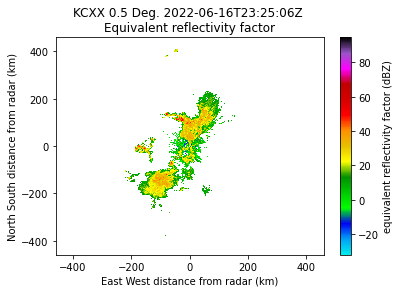

In [18]:
d = pyart.graph.RadarDisplay(radar)
d.plot_ppi('reflectivity', sweep=0, cmap='pyart_NWSRef')

Note the "sweep" keyword argument in the function above. Recall that radars scan at different angles, starting with a low level scan and moving up to create what's called a _volume_. Each angle is called a tilt or a sweep. The lowest tilt is 0.5 degrees above horizontal and then subsequent tilts happen in a set pattern. For instance the second tilt (you'll call it tilt 1 here, since the index starts at 0), is 0.9 degrees, the third is 1.3, and they continue to go up from there. You can play around with the sweep number and check the titles to see what the elevation angle actually is for each sweep. e.g. "KPAH 0.5 Deg." means the 0.5 degree tilt.

Your turn! In the cell below, make a PPI plot of _velocity_ in the lowest sweep. Use the cmap "pyart_NWSVel". You can use the same "d" RadarDisplay object created above.

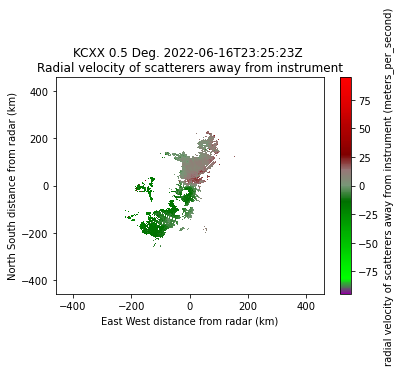

In [19]:
# Put your ppi plot here
d.plot_ppi('velocity', sweep=1, cmap='pyart_NWSVel')

/aos/home/ddiaz/miniconda3/envs/pyart_env/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/aos/home/ddiaz/miniconda3/envs/pyart_env/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


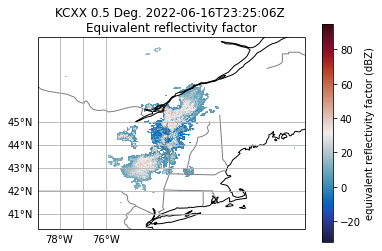

In [20]:
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map('reflectivity', sweep=0, resolution='50m',
                     projection=ccrs.PlateCarree(), cmap='pyart_balance')
       

You can also make an RHI plot, which is a good way to visualize how the beam height changes with distance from radar. For example, see the reflectivity RHI for sweep 0 (the lowest sweep) below.

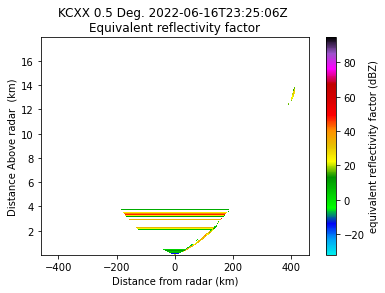

In [21]:
d.plot_rhi('reflectivity', sweep=0, cmap='pyart_NWSRef')

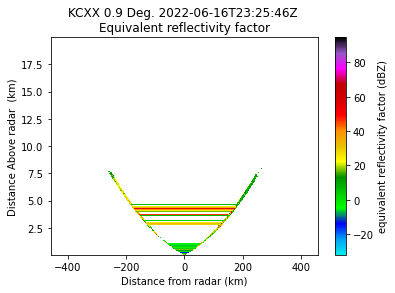

In [22]:
# Here, make an RHI plot of reflectivity for sweep 2, i.e. the 1.3 degree tilt
d.plot_rhi('reflectivity', sweep=2, cmap='pyart_NWSRef')

Using the RHI plots above and your distance from the radar calculated earlier, estimate the height of the radar beam at your location. You can do this one of two ways:

1). Use the `d.set_limits()` method shown [here](https://arm-doe.github.io/pyart/API/generated/pyart.graph.RadarDisplay.set_limits.html) to create a zoomed in RHI plot and estimate from there.

2) Use the `radar.get_gate_lat_lon_alt()` function [here](https://arm-doe.github.io/pyart-docs-travis/API/generated/pyart.core.Radar.get_gate_lat_lon_alt.html). Remember you have the index of the nearest point to your location in index_to_nn!

In [23]:
# since 1 degree = 111 km
km_away = degrees_away*111

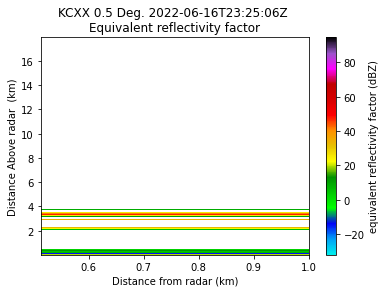

In [24]:
# Estimate height of radar beam in this cell
d.set_limits(km_away)
d.plot_rhi('reflectivity', sweep=0, cmap='pyart_NWSRef')

`From the plot above we can see that the height of the radar beam at my location is 4 km`

Answer in the below markdown cell: what are the implications of this beam height for severe weather forecasting? How about precipitation type detection?

**Put answers here**

Use the velocity field and index_of_nn to get the velocity at your location. Is this representative of the true wind speed at your location? Why or why not? (I have two reasons in mind here)

**Put answers here**

For the next exercise we'll start using this for more fun stuff!